# Calibration example

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import bootstrap
from radiocalibrationtoolkit import *

[INFO] LFmap: Import successful.


In [2]:
# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [3]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 14

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [4]:
# for this example you need to create a mock power dataframe and simulated sidereal power dataset

## Calibrate with "true"

In [5]:
# in this case the recorded is the mock dataset
sky_map_model = "LFmap"

power_rec_DF = pd.read_csv(
    "./mock_power_datasets/mock_power_dataset-Salla_EW_"
    + sky_map_model
    + "_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv",
    index_col=0,
)

power_rec_DF.columns = power_rec_DF.columns.astype(float)

dir_path = "./simulated_power_datasets/"
df_files = [
    os.path.join(dir_path, i)
    for i in os.listdir(dir_path)
    if (i.endswith(".csv") & i.startswith("Salla_EW"))
]
file_path_2_true = [i for i in df_files if sky_map_model in i][0]
power_sim_DF = pd.read_csv(file_path_2_true, index_col=0)
power_sim_DF.columns = power_sim_DF.columns.astype(float)

antenna_type = "Salla_EW"
dir_path = "./simulated_power_datasets/"

concatenated_sim_df = concatenate_simulated_dfs(dir_path, antenna_type)

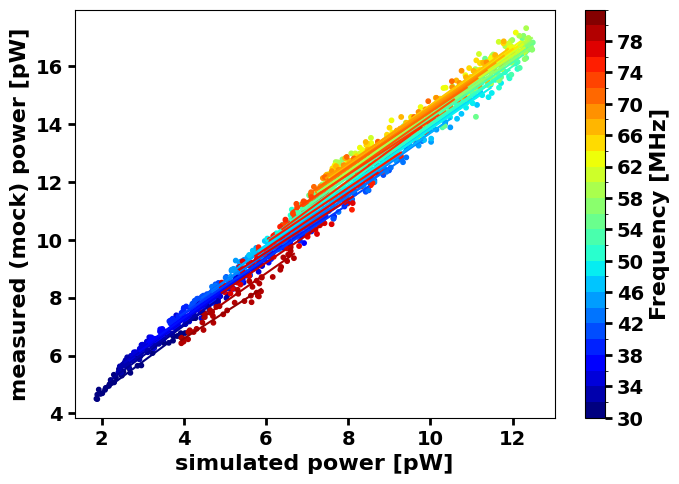

In [6]:
# fit each band and make a plot overview
cmapT = plt.get_cmap("jet")
bounds = np.arange(30, 83, 2)
norm = mpl.colors.BoundaryNorm(bounds, cmapT.N)

fig, ax = plt.subplots(figsize=(8, 6))

frequencies_MHz = power_sim_DF.columns.values
slopes = []
intercepts = []
for i, freq in enumerate(power_sim_DF.columns):
    c = [freq] * power_rec_DF.index.size
    x_arr = power_sim_DF.loc[:, freq].values
    y_arr = power_rec_DF.loc[:, freq].values
    cs = ax.scatter(x_arr, y_arr, s=10, c=c, norm=norm, cmap="jet")

    intercept, slope = robust_regression(x_arr, y_arr)
    intercepts.append(intercept)
    slopes.append(slope)
    x_new = np.linspace(np.min(x_arr), np.max(x_arr), 100)
    ax.plot(
        x_new,
        x_new * slope + intercept,
        color=cmapT((freq - np.min(bounds)) * (bounds[1] - bounds[0]) / 100),
    )

intercepts = np.asarray(intercepts) ** (1 / 2)
slopes = np.asarray(slopes) ** (1 / 2)

cbar = fig.colorbar(cs, ticks=np.arange(30, 81, 4), ax=ax)
cbar.set_label("Frequency [MHz]")
ax.set_xlabel("simulated power [pW]")
ax.set_ylabel("measured (mock) power [pW]")
fig.subplots_adjust(left=0.15, bottom=0.2)

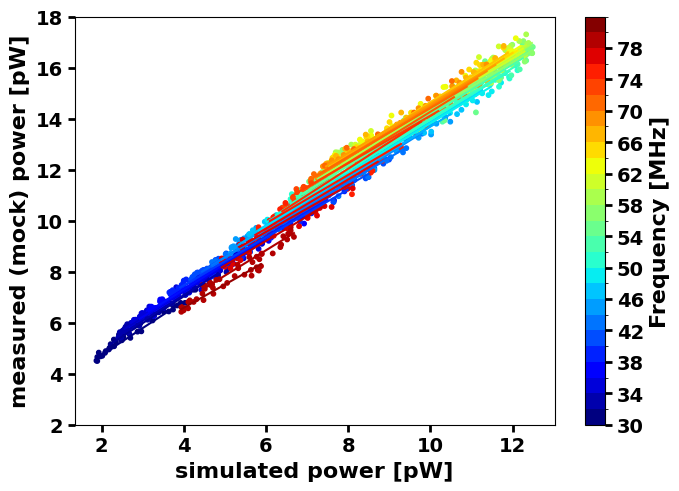

In [7]:
fig_data = pickle.dumps(fig)
fig2 = pickle.loads(fig_data)

# modify the axis limits of the copied figure
ax2 = fig2.axes
ax2[0].set_ylim(2, 18)
fig2

Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0006078210993757382
Test2: p0.5=-0.0006078210993664124
Test3: p0.5+/-0.341=-0.0018969865284672593
0.9959979989994998 0.9455727863931966 1.0473236618309154
Normalization test:  (0.9999996826650178, 8.579063148750484e-06)


(0.9959979989994998, 0.9455727863931966, 1.048224112056028)

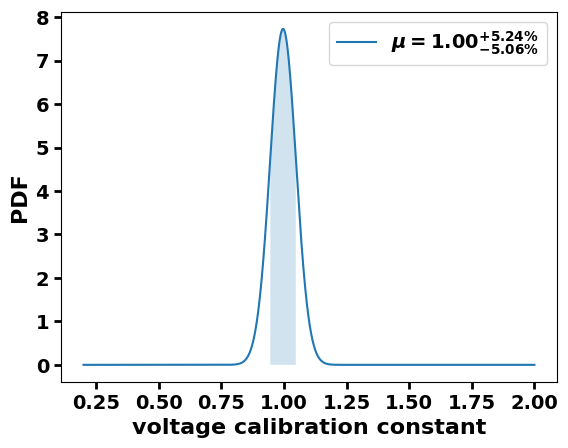

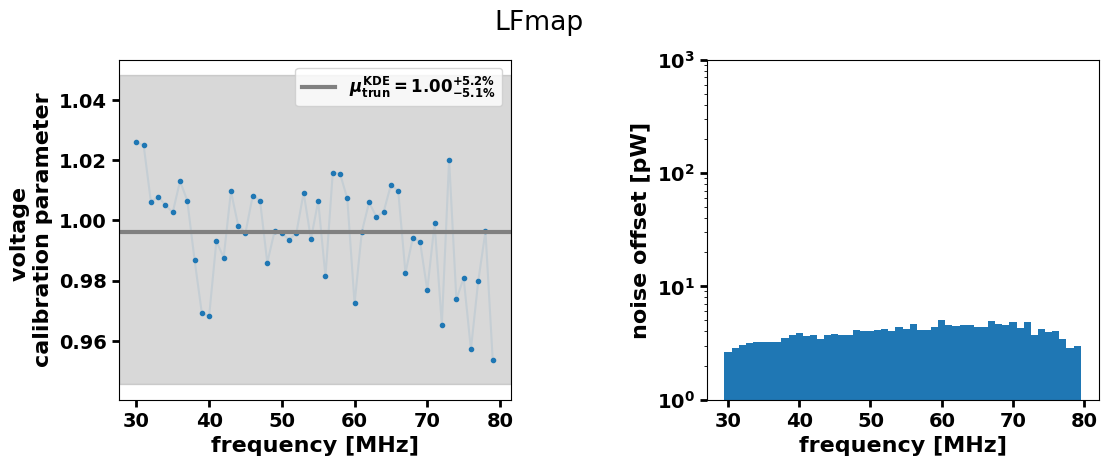

In [8]:
slopes_DF, intercepts_DF = get_fitted_voltage_calibration_params_and_noise_offsets(power_sim_DF, power_rec_DF)
get_and_plot_calibration_results(slopes_DF, intercepts_DF, title=sky_map_model, labels=None)

## Calibrate with all 'not true' simulated datasets

In [9]:
df_list = []
df_names = []
except_this = "Salla_EW_"+sky_map_model
for f in df_files:
    if except_this not in f:
        df = pd.read_csv(f, index_col=0)
        df.columns = df.columns.astype(float)
        df_list.append(df)
        df_names.append(Path(f).stem)

concatenated_sim_df = pd.concat(df_list, keys=df_names)
# check keys
[key for key in concatenated_sim_df.index.levels[0]]

['Salla_EW_GMOSS',
 'Salla_EW_ULSA',
 'Salla_EW_GSM08',
 'Salla_EW_Haslam',
 'Salla_EW_SSM',
 'Salla_EW_LFSS',
 'Salla_EW_GSM16']

Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0017821772044139261
Test2: p0.5=0.0017821772044235296
Test3: p0.5+/-0.341=0.00038797491434039433
1.0635317658829415 1.0023011505752877 1.125662831415708
Normalization test:  (1.0000005335287563, 4.765854054744162e-06)


(1.0635317658829415, 1.0023011505752877, 1.1265632816408204)

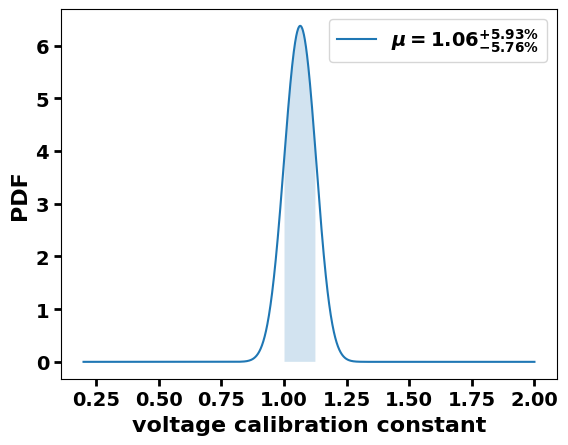

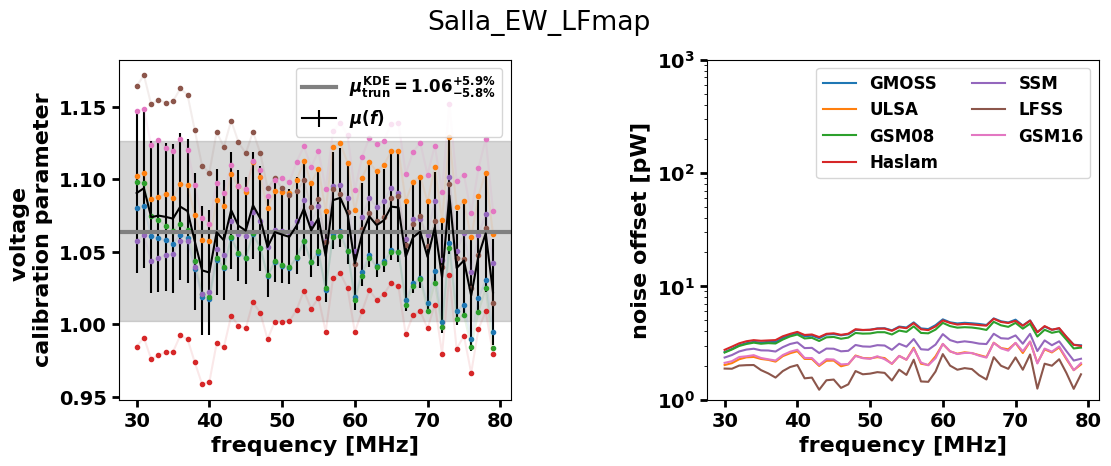

In [10]:
(
    slopes_DF,
    intercepts_DF,
) = get_fitted_voltage_cal_params_and_noise_offsets_from_concat_sim_dfs(
    concatenated_sim_df, power_rec_DF
)
get_and_plot_calibration_results(slopes_DF, intercepts_DF, title=except_this)

## Iteratively apply the previous procedure to all simulated datasets

In [11]:
# for this example you need to create a mock power dataframe and simulated sidereal power dataset

************************
GSM16
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_ULSA' 'Salla_EW_GSM08' 'Salla_EW_Haslam'
 'Salla_EW_LFmap' 'Salla_EW_SSM' 'Salla_EW_LFSS']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.002174319595923735
Test2: p0.5=-0.0021743195959137984
Test3: p0.5+/-0.341=-0.002416614628958702
0.9356678339169586 0.8753376688344172 0.9968984492246125
Normalization test:  (0.9999997607912533, 3.2552056166181145e-06)
************************
************************
LFSS
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_ULSA' 'Salla_EW_GSM08' 'Salla_EW_Haslam'
 'Salla_EW_LFmap' 'Salla_EW_SSM' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0026656882041229957
Test2: p0.5=0.002665688204132599
Test3: p0.5+/-0.341=0.0016228715234236635
0.9527763881940972 0.8897448724362182 1.0185092546273138
Normalization test:  (0.9999996116825947, 4.973531270917492e-06)
************************
************************
GSM08
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_ULSA' 'Salla_EW_Haslam' 'Salla_EW_LFmap'
 'Salla_EW_SSM' 'Salla_EW_LFSS' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-5.328442671259648e-06
Test2: p0.5=5.32844268053001e-06
Test3: p0.5+/-0.341=0.0008446868516868156
1.0104052026013006 0.944672336168084 1.0752376188094048
Normalization test:  (0.9999999429835957, 6.576854751385293e-06)
************************
************************
Haslam
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_ULSA' 'Salla_EW_GSM08' 'Salla_EW_LFmap'
 'Salla_EW_SSM' 'Salla_EW_LFSS' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.002244839314243019
Test2: p0.5=-0.0022448393142333045
Test3: p0.5+/-0.341=0.0021073689429030873
1.056328164082041 0.991495747873937 1.1202601300650326
Normalization test:  (1.0000010415098421, 5.853550830967539e-06)
************************
************************
LFmap
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_ULSA' 'Salla_EW_GSM08' 'Salla_EW_Haslam'
 'Salla_EW_SSM' 'Salla_EW_LFSS' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0017821772044139261
Test2: p0.5=0.0017821772044235296
Test3: p0.5+/-0.341=0.00038797491434039433
1.0635317658829415 1.0023011505752877 1.125662831415708
Normalization test:  (1.0000005335287563, 4.765854054744162e-06)
************************
************************
SSM
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_ULSA' 'Salla_EW_GSM08' 'Salla_EW_Haslam'
 'Salla_EW_LFmap' 'Salla_EW_LFSS' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.002420342610871651
Test2: p0.5=-0.002420342610862103
Test3: p0.5+/-0.341=6.598389102518976e-05
0.9869934967483742 0.9203601800900452 1.054527263631816
Normalization test:  (0.9999996083730416, 6.945302130818199e-06)
************************
************************
GMOSS
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_ULSA' 'Salla_EW_GSM08' 'Salla_EW_Haslam' 'Salla_EW_LFmap'
 'Salla_EW_SSM' 'Salla_EW_LFSS' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0024821799085868457
Test2: p0.5=0.002482179908596338
Test3: p0.5+/-0.341=0.000974668134731016
1.0131065532766383 0.9482741370685344 1.078839419709855
Normalization test:  (0.9999999948079411, 7.262696357398249e-06)
************************
************************
ULSA
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


['Salla_EW_GMOSS' 'Salla_EW_GSM08' 'Salla_EW_Haslam' 'Salla_EW_LFmap'
 'Salla_EW_SSM' 'Salla_EW_LFSS' 'Salla_EW_GSM16']
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.00165208727835231
Test2: p0.5=-0.001652087278342762
Test3: p0.5+/-0.341=0.0009122554419006557
0.9509754877438721 0.887943971985993 1.015807903951976
Normalization test:  (0.999999676719685, 5.043118322643974e-06)
************************


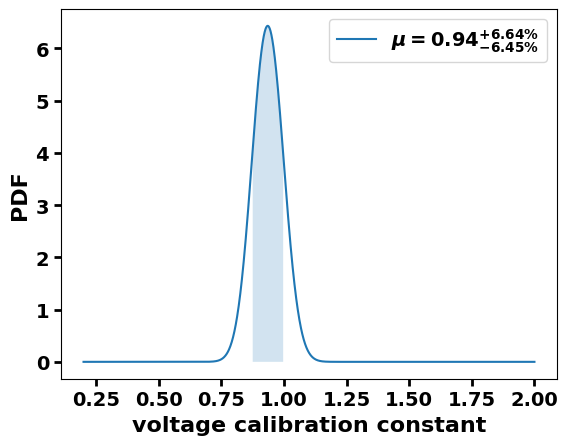

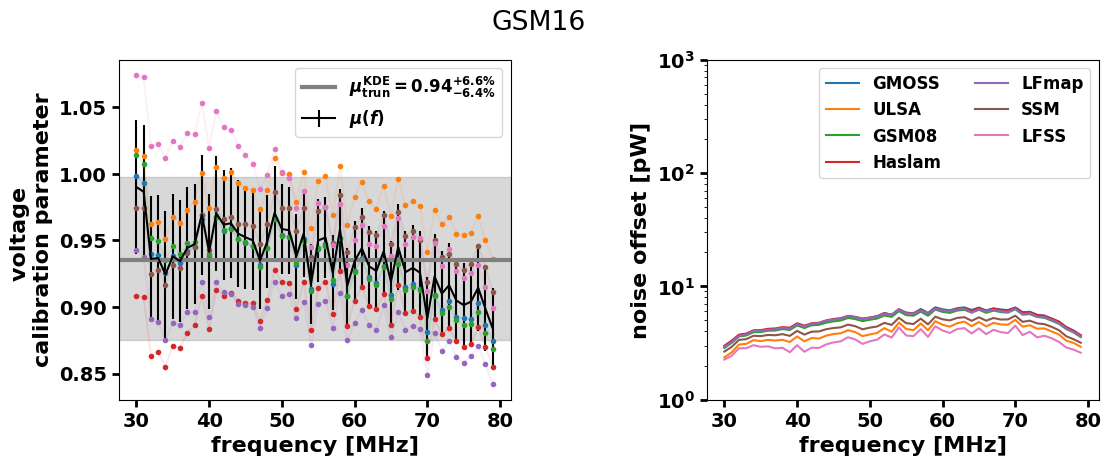

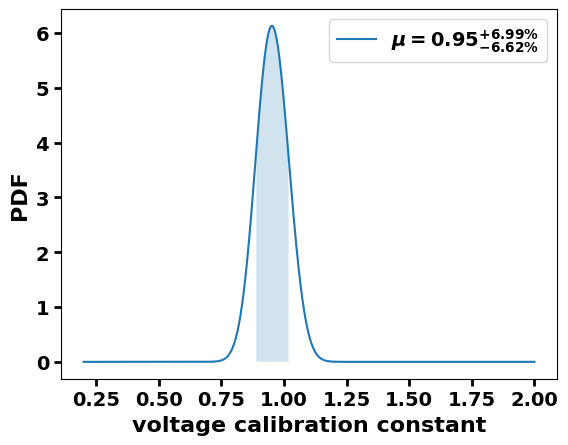

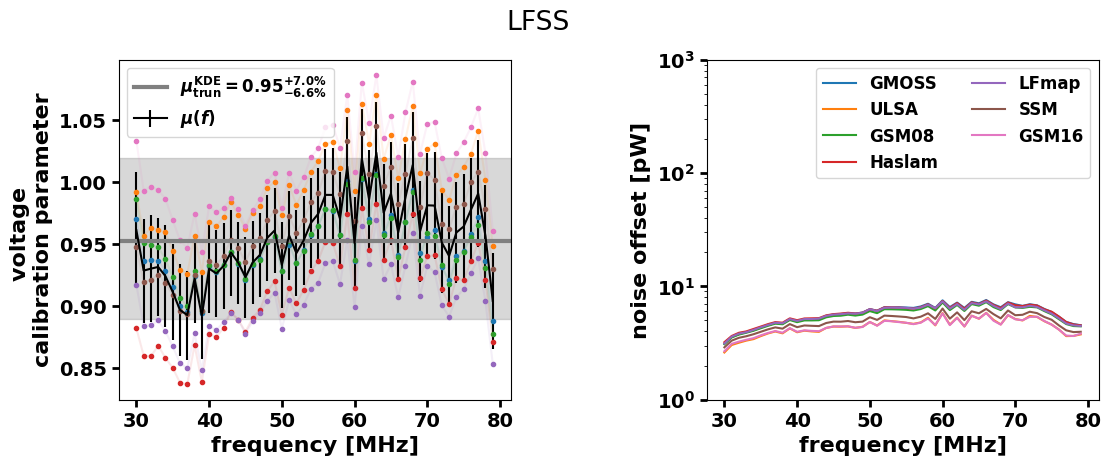

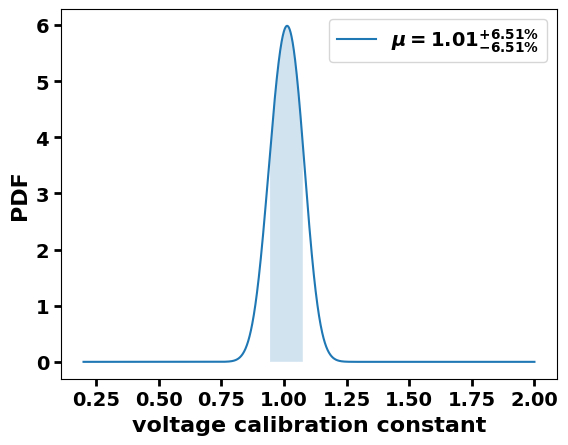

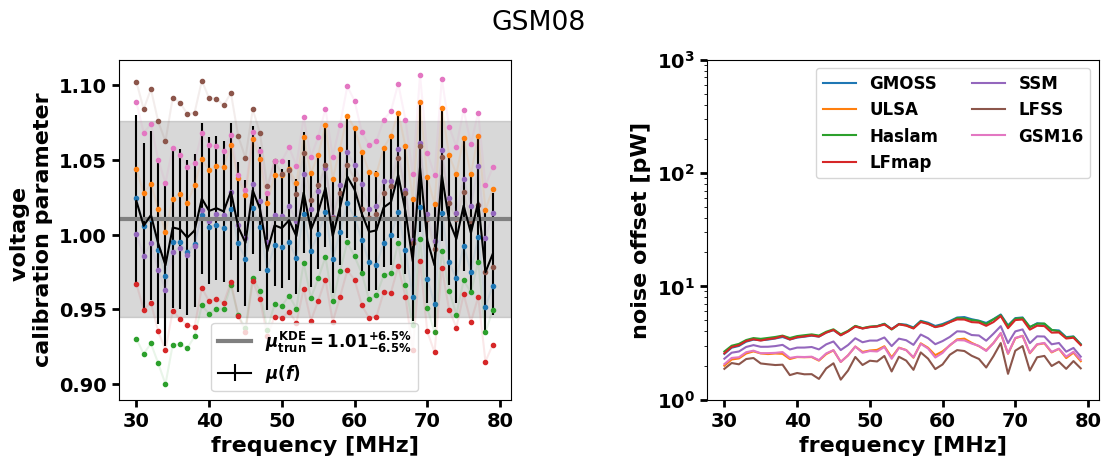

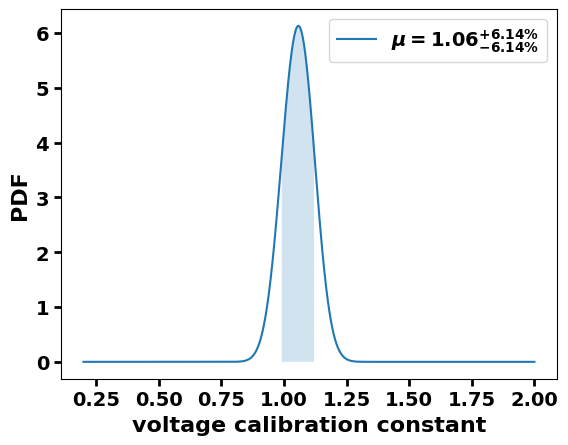

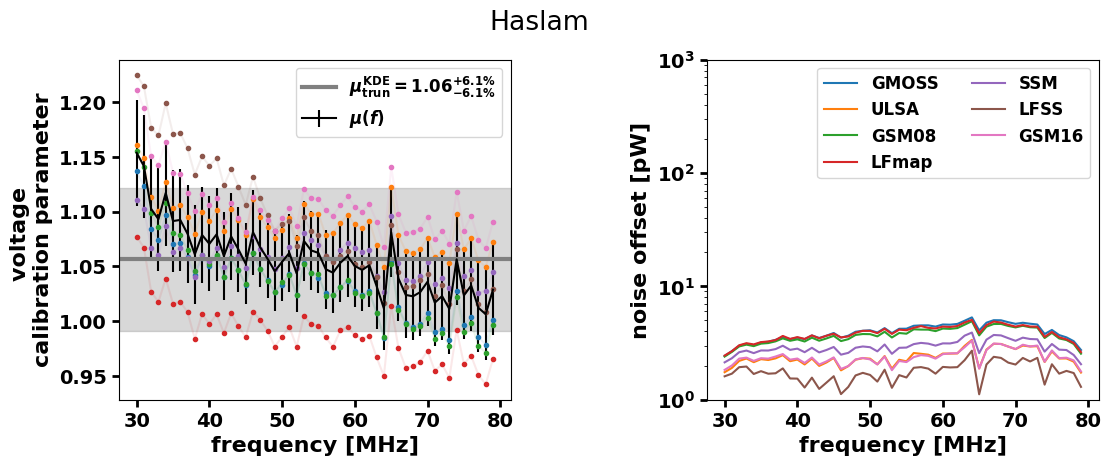

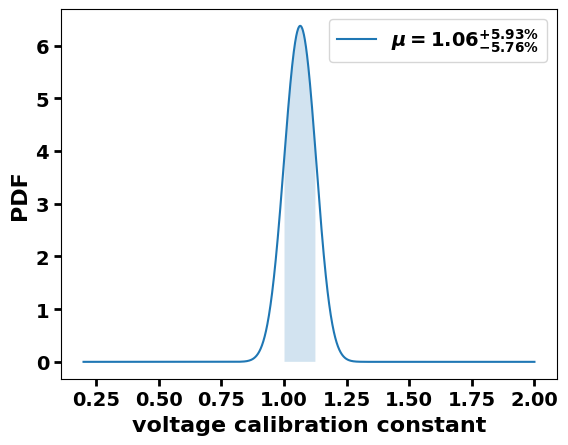

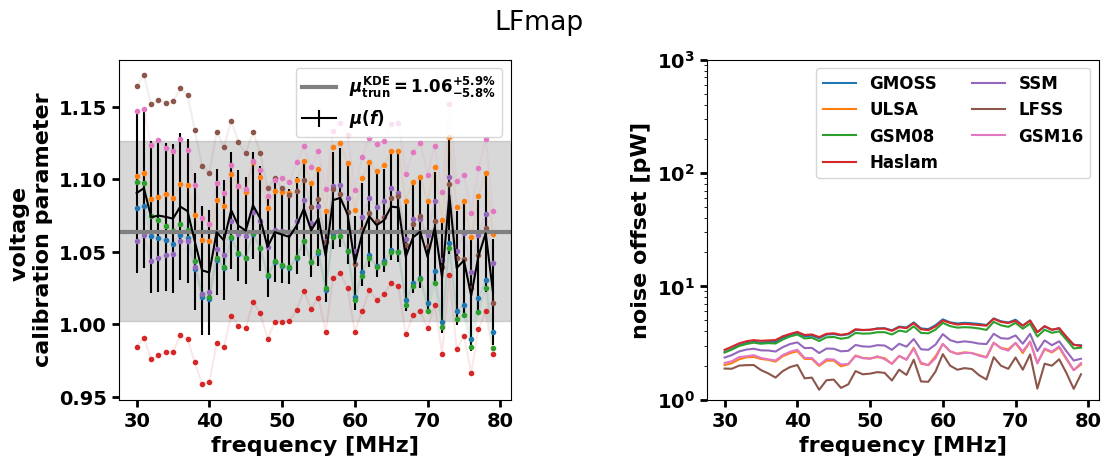

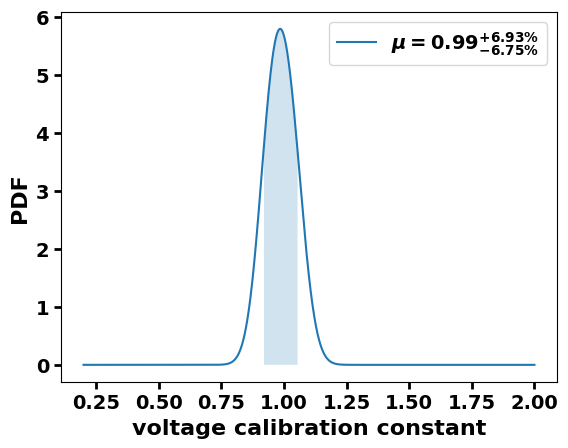

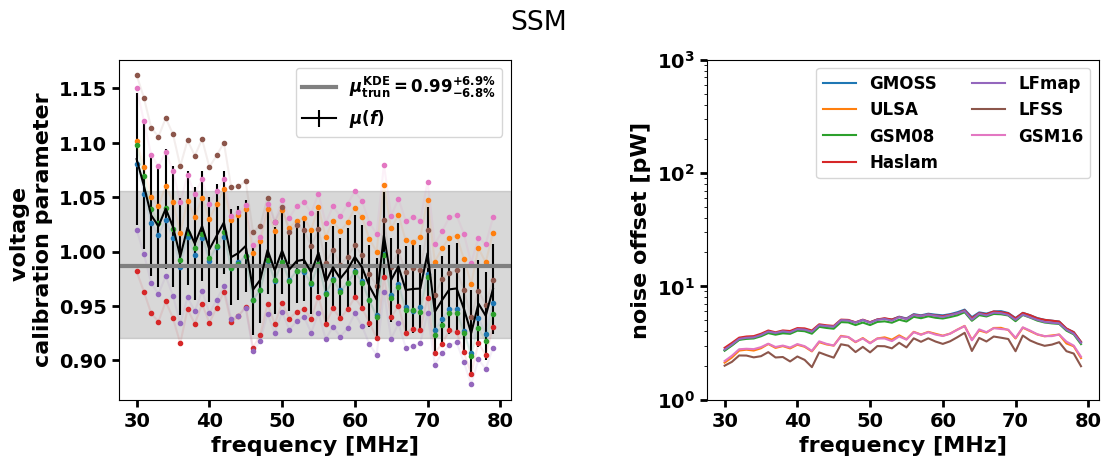

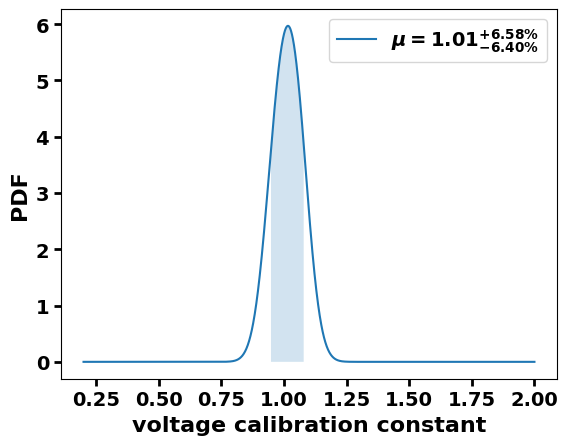

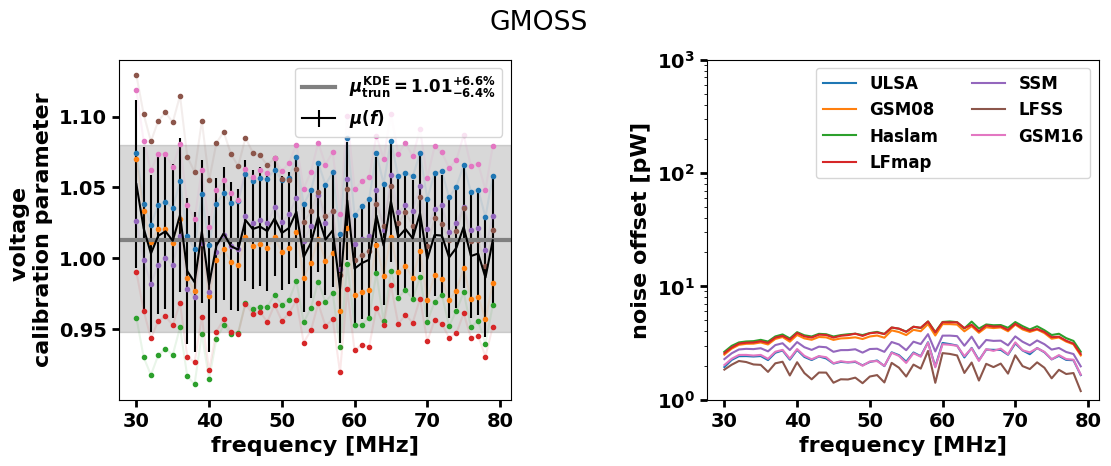

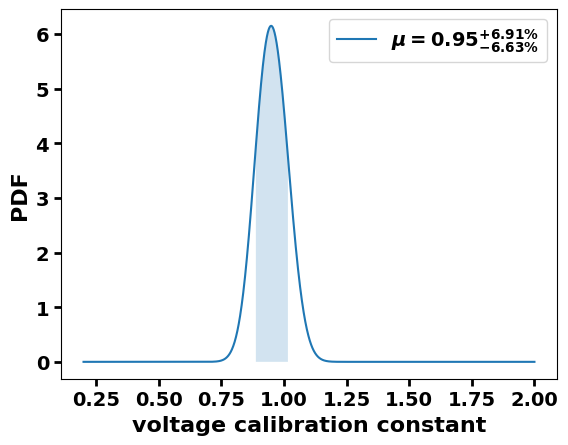

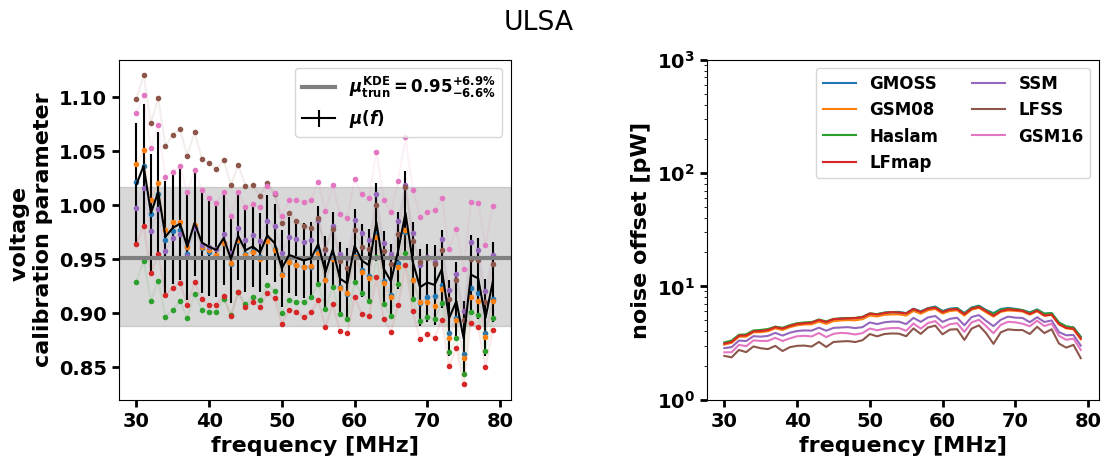

In [12]:
galactic_models = [
    "GSM16",
    "LFSS",
    "GSM08",
    "Haslam",
    "LFmap",
    "SSM",
    "GMOSS",
    "ULSA",
]

all_freq_dep_cal_params_dict = {}
all_freq_dep_noise_dict = {}
central_stats_dict = {}
for gmodel in galactic_models:
    print("************************")
    print(gmodel)
    df_list = []
    df_names = []
    measured_label = "Salla_EW_" + gmodel
    for f in df_files:
        # if measured_label not in f:
        df = pd.read_csv(f, index_col=0)
        df.columns = df.columns.astype(float)
        df_list.append(df)
        df_names.append(Path(f).stem)

    print(df_names)
    concatenated_sim_df = pd.concat(df_list, keys=df_names)
    power_rec_DF = pd.read_csv(
        "./mock_power_datasets/mock_power_dataset-"
        + measured_label
        + "_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv",
        index_col=0,
    )
    power_rec_DF.columns = power_rec_DF.columns.astype(float)
    (
        slopes_DF,
        intercepts_DF,
    ) = get_fitted_voltage_cal_params_and_noise_offsets_from_concat_sim_dfs(
        concatenated_sim_df, power_rec_DF
    )
    all_freq_dep_cal_params_dict[gmodel], all_freq_dep_noise_dict[gmodel] = (
        slopes_DF,
        intercepts_DF,
    )
    # central_stats_dict[gmodel] = get_and_plot_calibration_results(
    #     slopes_DF, intercepts_DF, title=gmodel
    # )
    # exclude the "true" from the KDE calculations and plots
    mask = slopes_DF.index != measured_label
    print(slopes_DF[mask].index.values)
    central_stats_dict[gmodel] = get_and_plot_calibration_results(
        slopes_DF[mask], intercepts_DF[mask], title=gmodel
    )
    print("************************")
    # fig = plt.gcf()
    # fig.savefig('with_not_true_{}.png'.format(gmodel), bbox_inches = 'tight')

In [13]:
all_slopes_df = pd.concat(all_freq_dep_cal_params_dict)
all_intercepts_df = pd.concat(all_freq_dep_noise_dict)
central_stats_DF = pd.DataFrame(central_stats_dict, index=["mu", "err_low", "err_high"]).T

Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations


Test1: p0.5=0.0009805924107588737
Test2: p0.5=-0.0009805924107481045
Test3: p0.5+/-0.341=0.0012921728570519653
0.9959979989994998 0.924862431215608 1.068934467233617
Normalization test:  (0.9999999657393277, 4.9459300101264076e-06)


(0.9959979989994998, 0.924862431215608, 1.0698349174587294)

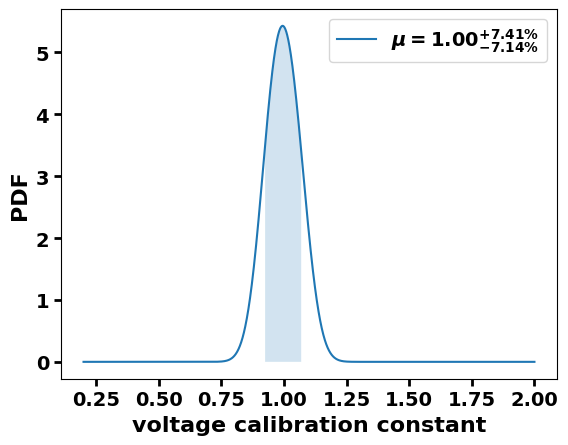

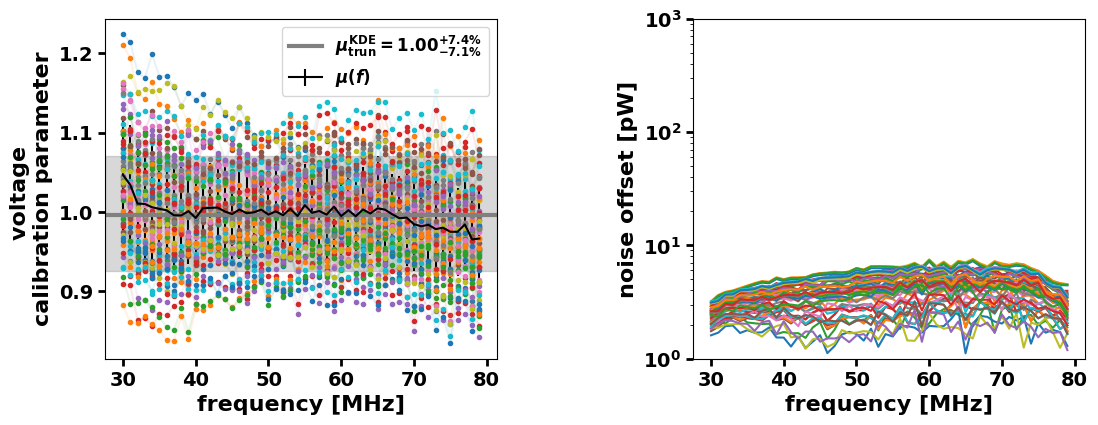

In [14]:
get_and_plot_calibration_results(all_slopes_df, all_intercepts_df, title="", labels=None)

In [15]:
# calculate calibration parameters for each scenario
cal_params = {}
cal_params_neg_err = {}
cal_params_pos_err = {}

for k in all_freq_dep_cal_params_dict.keys():
    temp_df = all_freq_dep_cal_params_dict[k]
    cal_params[k] = []
    cal_params_neg_err[k] = []
    cal_params_pos_err[k] = []
    print(temp_df.index)
    for row in temp_df.index:
        print('{} vs {}'.format(k, row))
        left, right, center = get_frequency_independent_calibration_param(temp_df.loc[row,:])
        cal_params[k].append(center)
        cal_params_neg_err[k].append(left - center)
        cal_params_pos_err[k].append(right - center)

Index(['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam',
       'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16'],
      dtype='object')
GSM16 vs Salla_EW_GMOSS
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0025977884407848983
Test2: p0.5=0.0025977884407942797
Test3: p0.5+/-0.341=0.0005314665037673416
0.9302651325662832 0.8771385692846423 0.9842921460730365
Normalization test:  (1.000000069398638, 6.375856491796777e-06)
GSM16 vs Salla_EW_ULSA
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.000419782766687693
Test2: p0.5=0.00041978276669707437
Test3: p0.5+/-0.341=-0.0013414363124913953
0.9788894447223613 0.9275637818909455 1.0311155577788895
Normalization test:  (0.9999992795819773, 1.8077718352672214e-06)
GSM16 vs Salla_EW_GSM08
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.000721429509729532
Test2: p0.5

Test1: p0.5=0.0003213812894785617
Test2: p0.5=-0.00032138128946940236
Test3: p0.5+/-0.341=0.0021444433863542223
1.0167083541770885 0.9644822411205602 1.0698349174587294
Normalization test:  (1.0000001348560674, 4.8228843200935005e-06)
GSM08 vs Salla_EW_LFSS
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.00264952742172464
Test2: p0.5=-0.002649527421715314
Test3: p0.5+/-0.341=-6.172130232573458e-06
1.046423211605803 0.9896948474237119 1.1040520260130064
Normalization test:  (0.9999996080916841, 8.339899705942322e-06)
GSM08 vs Salla_EW_GSM16
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0031582225568113076
Test2: p0.5=-0.003158222556801926
Test3: p0.5+/-0.341=0.0005006982011835914
1.0626313156578289 1.0113056528264133 1.1148574287143573
Normalization test:  (1.0000013700983112, 6.797669813604263e-06)
Index(['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam',
       'Salla_EW_

Test1: p0.5=-0.0030194568811016675
Test2: p0.5=0.003019456881111049
Test3: p0.5+/-0.341=0.0009558244431879803
1.025712856428214 0.9743871935967985 1.078839419709855
Normalization test:  (0.9999984069325026, 9.06606485493968e-06)
SSM vs Salla_EW_GSM08
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.00022993596784925963
Test2: p0.5=-0.00022993596783993375
Test3: p0.5+/-0.341=-0.0004490853935299466
0.9752876438219109 0.9194597298649325 1.0329164582291146
Normalization test:  (0.9999994340149818, 1.2262801082079634e-06)
SSM vs Salla_EW_Haslam
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0007731433732027226
Test2: p0.5=0.000773143373212104
Test3: p0.5+/-0.341=-0.003728180700647288
0.9374687343671837 0.8870435217608805 0.9887943971985993
Normalization test:  (1.0000002430579065, 2.144774216352839e-06)
SSM vs Salla_EW_LFmap
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterat

Test1: p0.5=-0.0010821419820173372
Test2: p0.5=0.0010821419820264966
Test3: p0.5+/-0.341=0.0011846430443174238
0.991495747873937 0.9284642321160581 1.0599299649824914
Normalization test:  (0.9999995294573594, 8.71098639587627e-06)
ULSA vs Salla_EW_GSM16
Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0002080986248441108
Test2: p0.5=0.00020809862485327013
Test3: p0.5+/-0.341=-0.0019203843415077637
1.0086043021510755 0.95727863931966 1.0617308654327164
Normalization test:  (1.0000000159264677, 5.774714080926682e-06)


In [16]:
all_cal_params_df = (
    pd.DataFrame.from_dict(
        cal_params, orient="index", columns=[i.replace("Salla_EW_", "") for i in temp_df.index]
    )
    .sort_index()
    .sort_index(axis=1)
).round(2)
all_cal_params_neg_errs_df = (
    pd.DataFrame.from_dict(
        cal_params_neg_err, orient="index", columns=[i.replace("Salla_EW_", "") for i in temp_df.index]
    )
    .sort_index()
    .sort_index(axis=1)
).round(2)
all_cal_params_pos_errs_df = (
    pd.DataFrame.from_dict(
        cal_params_pos_err, orient="index", columns=[i.replace("Salla_EW_", "") for i in temp_df.index]
    )
    .sort_index()
    .sort_index(axis=1)
).round(2)

In [17]:
# Format the DataFrame values for LaTeX
formatted_df = (
    all_cal_params_df.applymap(lambda x: f"{x:.2f}")
    + "$^{+"
    + all_cal_params_pos_errs_df.astype(str)
    + "}_{"
    + all_cal_params_neg_errs_df.astype(str)
    + "}$"
)

In [18]:
# mean except the diagnoal "true" values
np.fill_diagonal(all_cal_params_df.values, np.nan)
display(all_cal_params_df)
# row-by-row means (add as last column)
display(pd.DataFrame(all_cal_params_df.mean(axis=1), columns=['mean']).round(2))
# column-by-column means (add as last row)
display(pd.DataFrame(all_cal_params_df.mean(axis=0), columns=['mean']).T.round(2))

,GMOSS,GSM08,GSM16,Haslam,LFSS,LFmap,SSM,ULSA
GMOSS,NaN,1.00,1.07,0.96,1.05,0.95,1.02,1.05
GSM08,0.99,NaN,1.06,0.95,1.05,0.95,1.02,1.04
GSM16,0.93,0.93,NaN,0.89,0.98,0.89,0.95,0.98
Haslam,1.03,1.03,1.10,NaN,1.08,0.99,1.06,1.09
LFSS,0.95,0.95,1.01,0.91,NaN,0.90,0.97,1.00
LFmap,1.04,1.04,1.11,1.00,1.09,NaN,1.06,1.09
SSM,0.98,0.98,1.04,0.94,1.02,0.93,NaN,1.03
ULSA,0.94,0.94,1.01,0.91,0.99,0.90,0.97,NaN


,mean
GMOSS,1.01
GSM08,1.01
GSM16,0.94
Haslam,1.05
LFSS,0.96
LFmap,1.06
SSM,0.99
ULSA,0.95


,GMOSS,GSM08,GSM16,Haslam,LFSS,LFmap,SSM,ULSA
mean,0.98,0.98,1.06,0.94,1.04,0.93,1.01,1.04


In [19]:
formatted_df['mean'] = pd.DataFrame(all_cal_params_df.mean(axis=1)).round(2).astype(str)
formatted_df = pd.concat([formatted_df, pd.DataFrame(all_cal_params_df.mean(axis=0), columns=['mean']).T.round(2).astype(str)], ignore_index=False)

In [20]:
# Convert the formatted DataFrame to a LaTeX table
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

s = formatted_df.style.apply(highlight_diag, axis=None)
latex_table = s.to_latex()
print(latex_table)
display(s)

\begin{tabular}{llllllllll}
 & GMOSS & GSM08 & GSM16 & Haslam & LFSS & LFmap & SSM & ULSA & mean \\
GMOSS & \background-coloryellow 1.00$^{+0.05}_{-0.05}$ & 1.00$^{+0.05}_{-0.05}$ & 1.07$^{+0.05}_{-0.05}$ & 0.96$^{+0.05}_{-0.05}$ & 1.05$^{+0.06}_{-0.06}$ & 0.95$^{+0.05}_{-0.05}$ & 1.02$^{+0.05}_{-0.05}$ & 1.05$^{+0.05}_{-0.05}$ & 1.01 \\
GSM08 & 0.99$^{+0.05}_{-0.05}$ & \background-coloryellow 1.00$^{+0.05}_{-0.05}$ & 1.06$^{+0.05}_{-0.05}$ & 0.95$^{+0.05}_{-0.05}$ & 1.05$^{+0.06}_{-0.06}$ & 0.95$^{+0.05}_{-0.05}$ & 1.02$^{+0.05}_{-0.05}$ & 1.04$^{+0.05}_{-0.05}$ & 1.01 \\
GSM16 & 0.93$^{+0.05}_{-0.05}$ & 0.93$^{+0.05}_{-0.05}$ & \background-coloryellow 0.99$^{+0.05}_{-0.05}$ & 0.89$^{+0.05}_{-0.05}$ & 0.98$^{+0.06}_{-0.06}$ & 0.89$^{+0.05}_{-0.05}$ & 0.95$^{+0.05}_{-0.05}$ & 0.98$^{+0.05}_{-0.05}$ & 0.94 \\
Haslam & 1.03$^{+0.06}_{-0.05}$ & 1.03$^{+0.06}_{-0.06}$ & 1.10$^{+0.05}_{-0.05}$ & \background-coloryellow 0.99$^{+0.05}_{-0.05}$ & 1.08$^{+0.08}_{-0.07}$ & 0.99$^{+0.05}_{-0.05}$

,GMOSS,GSM08,GSM16,Haslam,LFSS,LFmap,SSM,ULSA,mean
GMOSS,1.00$^{+0.05}_{-0.05}$,1.00$^{+0.05}_{-0.05}$,1.07$^{+0.05}_{-0.05}$,0.96$^{+0.05}_{-0.05}$,1.05$^{+0.06}_{-0.06}$,0.95$^{+0.05}_{-0.05}$,1.02$^{+0.05}_{-0.05}$,1.05$^{+0.05}_{-0.05}$,1.01
GSM08,0.99$^{+0.05}_{-0.05}$,1.00$^{+0.05}_{-0.05}$,1.06$^{+0.05}_{-0.05}$,0.95$^{+0.05}_{-0.05}$,1.05$^{+0.06}_{-0.06}$,0.95$^{+0.05}_{-0.05}$,1.02$^{+0.05}_{-0.05}$,1.04$^{+0.05}_{-0.05}$,1.01
GSM16,0.93$^{+0.05}_{-0.05}$,0.93$^{+0.05}_{-0.05}$,0.99$^{+0.05}_{-0.05}$,0.89$^{+0.05}_{-0.05}$,0.98$^{+0.06}_{-0.06}$,0.89$^{+0.05}_{-0.05}$,0.95$^{+0.05}_{-0.05}$,0.98$^{+0.05}_{-0.05}$,0.94
Haslam,1.03$^{+0.06}_{-0.05}$,1.03$^{+0.06}_{-0.06}$,1.10$^{+0.05}_{-0.05}$,0.99$^{+0.05}_{-0.05}$,1.08$^{+0.08}_{-0.07}$,0.99$^{+0.05}_{-0.05}$,1.06$^{+0.05}_{-0.05}$,1.09$^{+0.05}_{-0.05}$,1.05
LFSS,0.95$^{+0.05}_{-0.05}$,0.95$^{+0.05}_{-0.05}$,1.01$^{+0.06}_{-0.06}$,0.91$^{+0.06}_{-0.06}$,1.00$^{+0.05}_{-0.05}$,0.90$^{+0.05}_{-0.05}$,0.97$^{+0.06}_{-0.06}$,1.00$^{+0.06}_{-0.06}$,0.96
LFmap,1.04$^{+0.05}_{-0.05}$,1.04$^{+0.05}_{-0.05}$,1.11$^{+0.05}_{-0.05}$,1.00$^{+0.05}_{-0.05}$,1.09$^{+0.06}_{-0.06}$,1.00$^{+0.05}_{-0.05}$,1.06$^{+0.05}_{-0.05}$,1.09$^{+0.05}_{-0.05}$,1.06
SSM,0.98$^{+0.06}_{-0.05}$,0.98$^{+0.06}_{-0.06}$,1.04$^{+0.05}_{-0.05}$,0.94$^{+0.05}_{-0.05}$,1.02$^{+0.07}_{-0.06}$,0.93$^{+0.05}_{-0.05}$,1.00$^{+0.05}_{-0.05}$,1.03$^{+0.05}_{-0.05}$,0.99
ULSA,0.94$^{+0.06}_{-0.05}$,0.94$^{+0.06}_{-0.05}$,1.01$^{+0.05}_{-0.05}$,0.91$^{+0.05}_{-0.05}$,0.99$^{+0.07}_{-0.06}$,0.90$^{+0.05}_{-0.05}$,0.97$^{+0.05}_{-0.05}$,0.99$^{+0.05}_{-0.05}$,0.95
mean,0.98,0.98,1.06,0.94,1.04,0.93,1.01,1.04,nan


Min and Max observed bias:
0.9356678339169586 1.0635317658829415


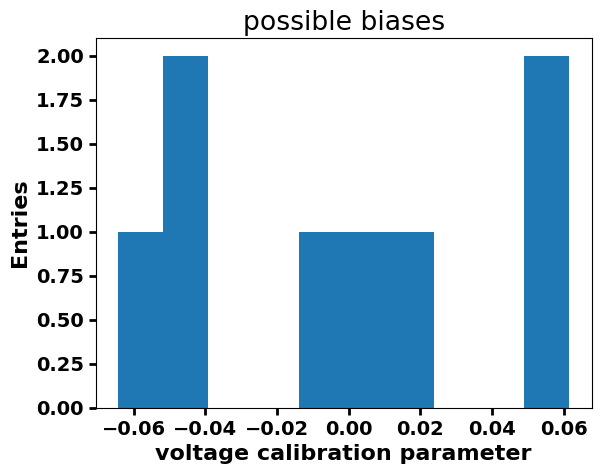

In [21]:
fig, ax = plt.subplots()
data = pd.DataFrame(all_cal_params_df.mean(axis=1)).values.flatten() - 1
ax.set_title("possible biases")
ax.hist(data)
ax.set_xlabel("voltage calibration parameter")
ax.set_ylabel("Entries")

print("Min and Max observed bias:")
print(np.min(central_stats_DF.mu.values), np.max(central_stats_DF.mu.values))

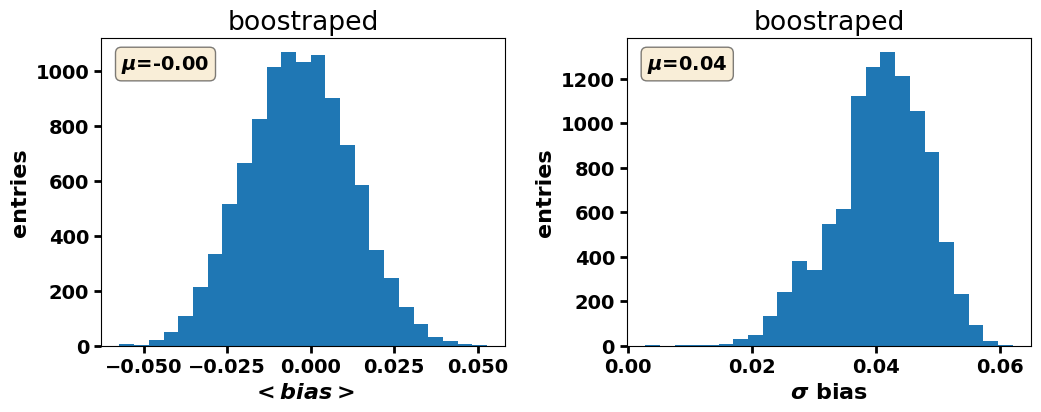

In [22]:
data = (data,)  # samples must be in a sequence

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
res = bootstrap(data, np.mean, confidence_level=0.9)
bvalues = res.bootstrap_distribution
ax[0].hist(bvalues, bins=25)
ax[0].set_title("boostraped")
ax[0].set_xlabel(r"$<bias>$")
ax[0].text(
    0.05,
    0.95,
    "$\mu$={:.2f}".format(np.mean(bvalues)),
    transform=ax[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=props,
)
ax[0].set_ylabel("entries")

ax[1].set_title("boostraped")
res = bootstrap(data, np.std, confidence_level=0.9)
bvalues = res.bootstrap_distribution
ax[1].hist(bvalues, bins=25)
ax[1].set_xlabel("$\sigma$ bias")
ax[1].text(
    0.05,
    0.95,
    "$\mu$={:.2f}".format(np.mean(bvalues)),
    transform=ax[1].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=props,
)
ax[1].set_ylabel("entries")
fig.subplots_adjust(wspace=0.3)